<a href="https://colab.research.google.com/github/ajibigad/ML-Playground/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.4 MB/s eta 0:00:00
Mounted at /content/gdrive


In [4]:
#hide
from fastbook import *

In [5]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [6]:
#hide
Path.BASE_PATH = path
path.ls()

(#2) [Path('annotations'),Path('images')]

In [7]:
(path/"images").ls()

(#7393) [Path('images/great_pyrenees_142.jpg'),Path('images/english_cocker_spaniel_57.jpg'),Path('images/staffordshire_bull_terrier_81.jpg'),Path('images/german_shorthaired_105.jpg'),Path('images/miniature_pinscher_138.jpg'),Path('images/pomeranian_192.jpg'),Path('images/chihuahua_17.jpg'),Path('images/Birman_123.jpg'),Path('images/Siamese_157.jpg'),Path('images/chihuahua_19.jpg')...]

In [8]:
fname = (path/"images").ls()[0]
re.findall(r'(.+)_\d+.jpg$', fname.name)

['great_pyrenees']

In [9]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

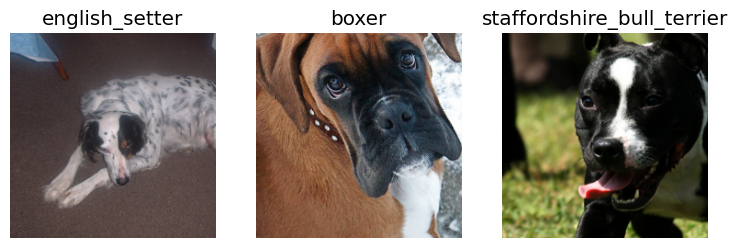

In [10]:
dls.show_batch(nrows=1, ncols=3)

In [11]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 79.9MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.518014,0.346875,0.889716,01:17


epoch,train_loss,valid_loss,accuracy,time
0,0.517042,0.313513,0.899865,01:15
1,0.330913,0.235818,0.933018,01:15


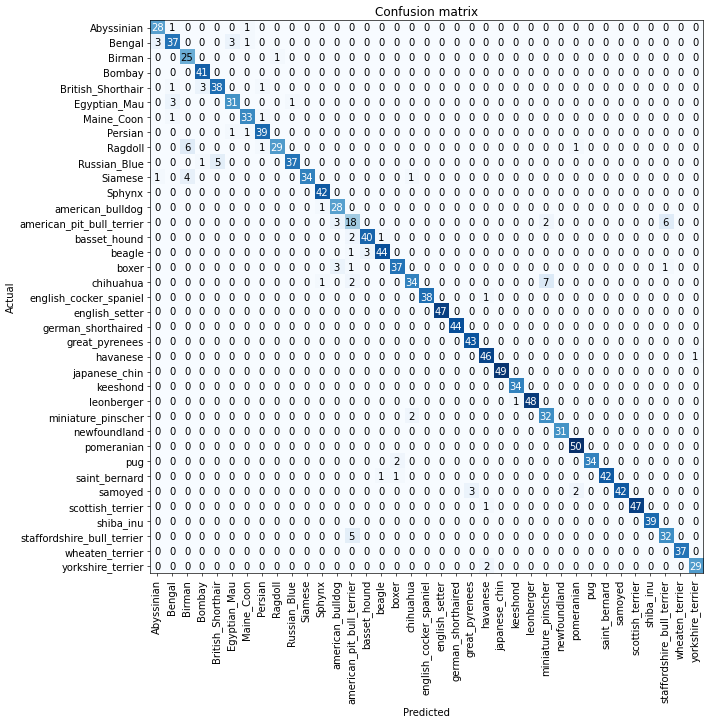

In [12]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [13]:
interp.most_confused(min_val=5)

[('chihuahua', 'miniature_pinscher', 7),
 ('Ragdoll', 'Birman', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Russian_Blue', 'British_Shorthair', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5)]

SuggestedLRs(minimum=0.010000000149011612, steep=0.002511886414140463, valley=0.0012022644514217973)

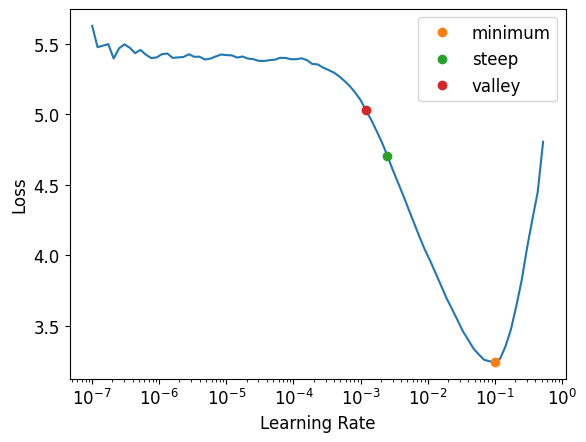

In [29]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.lr_find(suggest_funcs=(minimum, steep, valley))

In [19]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.302947,0.358775,0.889039,01:19


epoch,train_loss,valid_loss,accuracy,time
0,0.513574,0.388720,0.883627,01:25
1,0.321575,0.221807,0.924899,01:18


In [18]:
learn.fine_tune??

In [30]:
# train only output layer while other layers are frozen
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.160635,0.309518,0.906631,01:16
1,0.533814,0.247618,0.921516,01:10
2,0.336165,0.216639,0.935047,01:12


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Path('models/post_freeze_checkpoint.pth')

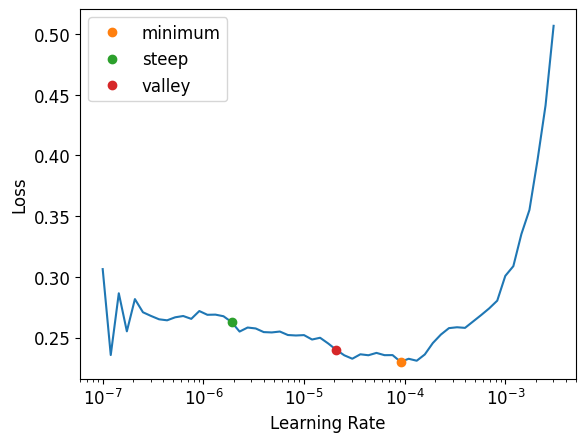

In [31]:
# Unfreeze frozen layers and find new learning rate
learn.unfreeze()
learn.lr_find(suggest_funcs=(minimum, steep, valley))
learn.save('post_freeze_checkpoint')

In [32]:
# Train entire model after unfreezing
learn.fit_one_cycle(6, lr_max=6.3e-7) # use steep

epoch,train_loss,valid_loss,accuracy,time
0,0.270330,0.216133,0.933694,01:14
1,0.256846,0.217693,0.931664,01:14
2,0.252168,0.211261,0.936401,01:14
3,0.260442,0.210738,0.935047,01:14
4,0.252947,0.210446,0.935047,01:12
5,0.243847,0.212298,0.933694,01:16


In [33]:
learn.load('post_freeze_checkpoint')
learn.fit_one_cycle(6, lr_max=3.01e-5) # use valley

epoch,train_loss,valid_loss,accuracy,time
0,0.255597,0.211607,0.935724,01:15
1,0.241044,0.213760,0.934371,01:15
2,0.201686,0.198745,0.935724,01:15
3,0.169951,0.185240,0.941813,01:13
4,0.143474,0.180285,0.945873,01:13
5,0.120214,0.182964,0.942490,01:16


In [35]:
learn.load('post_freeze_checkpoint')
learn.fit_one_cycle(12, lr_max=slice(3.01e-6, 3.01e-4)) # discriminative learning rate

epoch,train_loss,valid_loss,accuracy,time
0,0.257452,0.214925,0.937077,01:14
1,0.236060,0.205640,0.938430,01:16
2,0.224487,0.208520,0.935724,01:16
3,0.202628,0.212009,0.937754,01:16
4,0.169792,0.204847,0.941813,01:14
5,0.139302,0.203449,0.939107,01:18
6,0.111057,0.197631,0.945873,01:15
7,0.093559,0.200316,0.937754,01:14
8,0.071824,0.187533,0.941137,01:19
9,0.067320,0.187441,0.943166,01:14
